In [1]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'learn.ipynb'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'python', 'learn.ipynb'], returncode=4294967295)

In [2]:
import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
#from pdpbox import pdp
from Controllers import databases as db
from Controllers import transforms as tr
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
import xgboost as xgb
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D  #3Dplot
from sklearn.linear_model import LinearRegression

In [3]:


def config():
   # DataFrameを表示する際の折り返す横幅の設定
    pd.set_option('display.width', 200)

    # DataFrameを表示する際、全てのDataFrame を表示させる設定
    # デフォルトは一番最後のDataFrame一つのみ
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'

    # DataFrameを表示するとき、表示する行数
    # とりあえず最大５０００行表示するようにする
    pd.set_option('display.max_rows', 5000)

    # DataFrameを省略せず全部表示（多分ね）
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
    pd.set_option('display.max_columns', 100)

config()

### おそらく毎回承認が必要です。
# リンクを踏み、指示通りに進める。ログイン・アクセス権の許可後URLが表示されえる。それをコピー＆以下にペーストで完了。
is_google=False
if is_google:
    Folder ='drive/My Drive/doShare/lab/4_code/softkyushu_201911/predict_Detailes`'
    from google.colab import drive
    drive.mount('/content/drive')
else:
    Folder ='.'
        
fsize = (16,12)
fsize_title = 30
fsize_label = 20


## データの読み込み

In [4]:
#RECORD = db.getPreprocessedData()
#RECORD = RECORD.sort_values(by='start') 
#RECORD

In [5]:
#RECORD = db.getPreprocessedData()
#excretion = RECORD[RECORD['record_type'].isin(['排便量'])]
#excretion

In [6]:
#RECORD = RECORD[RECORD['act'] == '排泄']
#RECORD

翻訳

## 学習用関数

In [4]:
import sys
sys.setrecursionlimit(10000)

def train(X_train, X_test, Y_train, Y_test):
    parms = {'n_estimators':700 ,'max_depth':200, 'verbose':True}
    clf_ = RandomForestClassifier(random_state=10, n_estimators=parms['n_estimators'] , max_depth=parms['max_depth'], verbose=parms['verbose'])
    clf_.fit(X_train, Y_train)
    Y_predict = clf_.predict(X_test)
    confusionmatrix(Y_test, Y_predict)
    return clf_,Y_predict

def objective(trial):
    X_train = train_data[list_features]
    X_test = test_data[list_features]
    Y_train = train_data[target]
    Y_test = test_data[target]

    ## TODO : パラメータをタス
    min_samples_split = trial.suggest_int("min_samples_split", 8, 16)
    max_leaf_nodes = int(trial.suggest_discrete_uniform("max_leaf_nodes", 4, 64, 4))
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
    clf_ = RandomForestClassifier(min_samples_split = min_samples_split, 
                                max_leaf_nodes = max_leaf_nodes,
                                criterion = criterion)
    clf_ = RandomForestClassifier(random_state = 10, n_estimators = 700 ,max_depth = 200, verbose=True)
#     clf_.fit(X_train, Y_train)
    return 1.0 - accuracy_score(Y_test, clf_.predict(X_test))


    

    return clf_

def confusionmatrix(y_test, y_predict):
    mat = confusion_matrix(y_test, y_predict)
    sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
    plt.xlabel('predicted class')
    plt.ylabel('true value')

### Feature Importance

In [5]:
def importance(clf, train_columns, x_train, act, rec):
    '''
    重要度の計算・表示を行う
    文字として表示すると共に画像として出力もしている
    '''
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # カラム名を特徴量名に変換
    translate_features_jp = {
        'target_id':'被介護者',
        'ID_target_role':'被介護者の居住階',
        'user':'介護職員',
        'hour':'時刻(時)',
        'min_day':'時刻(15分刻み)',
        'ID_past_value':'前回の値',
        'main_amount':'前回の食事・服薬クラスの主食量',
        'main_amount_morning':'前回の食事・服薬クラスの主食量',
        'main_amount_morning':'前回の食事・服薬クラスの主食量',
        'main_amount_dinner':'前回の食事・服薬クラスの主食量',
        'main_amount_oyatsu':'前回の食事・服薬クラスの主食量',
        
        'sub_amount':'前回の食事・服薬クラスの副食量',
        'sub_amount_morning':'前回の食事・服薬クラスの副食量',
        'sub_amount_lunch':'前回の食事・服薬クラスの副食量',
        'sub_amount_dinner':'前回の食事・服薬クラスの副食量',
        'sub_amount_oyatsu':'前回の食事・服薬クラスの副食量',

        'water':'前回の食事・服薬クラスの水分量',
        'water_morning':'前回の食事・服薬クラスの水分量',
        'water_lunch':'前回の食事・服薬クラスの水分量',
        'water_dinner':'前回の食事・服薬クラスの水分量',
        'water_oyatsu':'前回の食事・服薬クラスの水分量',

        'meal_amount_morning':'朝食の食事量',
        'meal_amount_lunch':'昼食の食事量',
        'meal_amount_dinner':'夕食の食事量',
        'meal_amount_oyatsu':'おやつの食事量',
        'meal_amount_snack':'間食の食事量',

        'excretion':'前回の排泄クラスの排泄量',
    }
    tmp = pd.DataFrame(train_columns)
    train_columns_jp = list(tmp.replace(translate_features_jp)[0].values)

    # 特徴量重要度を数値で表示
    im = []
    im_f = []
    for f in range(x_train.shape[1]):
        im_f.append(train_columns[indices[f]])
        im.append(importances[indices[f]])
        print("%2d) %-*s %f" % (f + 1, 30, train_columns[indices[f]], importances[indices[f]]))

#     plt.figure(figsize=fsize)
#     plt.bar(range(x_train.shape[1]), 
#             importances,
#             align='center',
#             tick_label=train_columns_jp
#            )

    # 棒グラフに数値を表示
#     for x, y in zip(range(x_train.shape[1]), importances):
#         plt.text(x, y, round(y, 3), ha='center', va='bottom', fontsize=fsize_label)
    
#     plt.xticks(rotation=90, fontsize=fsize_label)
#     plt.tick_params(labelsize=fsize_label)
#     plt.ylim([0, 1])
#     plt.title('特徴量重要度[{0} : {1} ]'.format(act, rec), fontsize=fsize_title)
#     plt.xlabel('特徴量',fontsize=fsize_label)
#     plt.ylabel('重要度',fontsize=fsize_label)
#     plt.savefig('img/importance_{0}_{1}'.format(translate_act_dict[act], translate_act_record_type[rec]), bbox_inches='tight', dpi=300)
#     plt.show()

    dic_importance = {key: val for key, val in zip(im_f, im)}
    return dic_importance


### Confusion Matrix

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def confusionMatrix(y_test, y_pred, act, rec):
    labels_id = np.unique(y_test)
    
    d = dict_id2value
    v = np.array(list(d.values()))
    sidx = np.searchsorted(list(d), labels_id)
    labels_jp = v[sidx]

    sidx = np.searchsorted(list(d), y_test)
    y_test_jp = v[sidx]

    sidx = np.searchsorted(list(d), y_pred)
    y_pred_jp = v[sidx]

    cm = confusion_matrix(y_test_jp, y_pred_jp, labels=labels_jp)
    cm_df = pd.DataFrame(cm, columns=labels_jp, index=labels_jp)
    row, col = cm.shape
    fig, ax = plt.subplots(figsize=(17, 17))
    sns.heatmap(cm_df, cmap='Blues', annot=True, fmt='d', square=True)
    ax.set_ylim(col, 0)
    plt.yticks(rotation=0)
    plt.xlabel('推定ラベル',fontsize=fsize_label)
    plt.ylabel('正解ラベル',fontsize=fsize_label)
    plt.tick_params(labelsize=fsize_label)
    plt.savefig('img/CM_{0}_{1}'.format(translate_act_dict[act], translate_act_record_type[rec]), bbox_inches='tight')
    plt.show()
    LABELS = X_train.columns.values
    return cm

### Partial Dependece Plot

In [7]:
def parialDependencePlot(clf, x_train, x_test, feature, act, rec):
    fig = plt.figure(figsize=fsize)
    pdp_goals = pdp.pdp_isolate(
        model=clf, dataset=x_train,
        model_features=x_test.columns,
        feature=feature,
    )
    pdp.pdp_plot(pdp_goals,feature)
#     plt.title('Partial Dependece Plot["{0}" : "{1}"]'.format(act, rec),fontsize=fsize_title)
#     plt.xlabel('{0}の値'.format(feature),fontsize=fsize_label)
#     plt.ylabel('',fontsize=fsize_label)
    plt.tick_params(labelsize=fsize_label)
    plt.savefig('img/pdp_{0}_{1}_{2}'.format(translate_act_dict[act], translate_act_record_type[rec], f), bbox_inches='tight')
    plt.show()


## Features

In [8]:
#排尿量のための特徴量
list_features = [
#     'ID_act', 'ID_record_type',
    #'target_id',
    #'ID_target_role',
    #'user',
    'hour',
    #'min_day',
    #'week_day',
    #'ID_past_value',

    #'past_water_hour',
    'past_urination_hour'
    
]

target = 'future_urination_hour'

In [9]:
#排便量のための特徴量
list_features = [
#     'ID_act', 'ID_record_type',
    #'target_id',
    #'ID_target_role',
    #'user',
    'hour',
    #'min_day',
    #'week_day',
    #'ID_past_value',  
    'past_meal_hour',
    'past_excretion_hour'
    
]

target = 'future_excretion_hour'

In [13]:
RECORD = RECORD.fillna(0)
RECORD['start'] = pd.to_datetime(RECORD['start'])

## A : 全データで学習・レコードごとに精度を出す

### 人でクロスバリテーション

C:\Users\ucchi\OneDrive\ドキュメント\井上研究室\排泄研究プログラム\predict_Detailes-main\predict_Detailes-main\Controllers\transforms.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = record[record['start'] < pd.to_datetime('2018-06-15 00:00:00+09:00')][record['target_id'].isin(targets_train)]
C:\Users\ucchi\OneDrive\ドキュメント\井上研究室\排泄研究プログラム\predict_Detailes-main\predict_Detailes-main\Controllers\transforms.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = record[pd.to_datetime('2018-06-15 00:00:00+09:00') <= record['start']][record['target_id'].isin(targets_test)]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.8s finished


AttributeError: 'tuple' object has no attribute 'predict'

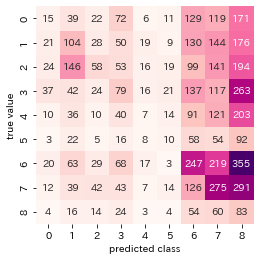

In [124]:
train_data, test_data = tr.getDataSplitByCustomer(RECORD_re)

## 学習
clf_temp1 = train(train_data[list_features], test_data[list_features], train_data[target], test_data[target])
X_test_temp = test_data[list_features]
Y_test_temp = test_data[target]

# 推定
Y_predict = clf_temp1.predict(X_test_temp)

# 再現率・適合率・F１値
f1 = classification_report(Y_test_temp, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(f1)

score = accuracy_score(Y_test_temp, Y_predict)
print("score : ", int(((score*100)+0.5)), "%(", score,")")

## ハイパーパラメータの自動最適化
# import optuna
# study = optuna.create_study()
# study.optimize(objective, n_trials = 100)
# study.best_params



In [19]:
# 学習結果を出力
result_all2record = []
for record_type_name in RECORD['record_type'].value_counts().index.values:
    print('==========', record_type_name, '===============')
    # テストデータX, Yを生成
    X_test_temp = test_data[test_data['record_type'] == record_type_name][list_features]
    Y_test_temp = test_data[test_data['record_type'] == record_type_name][target]

    # 推定
    Y_predict = clf_temp1.predict(X_test_temp)

    # Importance
    importances = importance(clf_temp1, list_features, train_data[list_features])

    # confusion matrix
    cm = confusionMatrix(Y_test_temp, Y_predict)

    # 再現率・適合率・F１値
    f1 = classification_report(Y_test_temp, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
    print(f1)

    # accuracy
    score = accuracy_score(Y_test_temp, Y_predict)

    prf = precision_recall_fscore_support(Y_test_temp, Y_predict, average="macro")
    result_all2record.append([record_type_name, round(score*100), cm, round(prf[0]*100, 1), round(prf[1]*100, 1), round(prf[2]*100, 1)])
    
    del X_test_temp
    del Y_test_temp
    del Y_predict
    del importances
    del cm
    del f1
    del prf

pd.DataFrame(result_all2record, columns = ['record_type_name', 'score', 'cm', 'precision', 'recall', 'f1']).to_csv(Folder + "/data/result_all2record.csv")

========== 種別 ===============


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.7s finished


TypeError: importance() missing 2 required positional arguments: 'act' and 'rec'

### クラスター事に学習

In [18]:
tmp_train_data, tmp_test_data = tr.getDataSplitByPeriod(RECORD)

## 0:[53, 55, 56, 57, 58, 59, 60, 61, 65, 67, 68, 71, 72, 73, 74, 75, 77, 79]
# targets_train = [53, 55, 56, 57, 58, 59, 60, 61, 65, 67, 68, 71]
# targets_test = [72, 73, 74, 75, 77, 79]
# 1: [ 84,  85,  88,  89,  92,  95,  98, 110, 120]
# targets_train = [ 84,  85,  88,  89,  92,  95]
# targets_test = [98, 110, 120]
## 2: [29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50]
targets_train = [29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42]
targets_test = [43, 44, 45, 48, 49, 50]

train_data = tmp_train_data[tmp_test_data['target_id'].isin(targets_train + targets_test)]
test_data = tmp_test_data[tmp_test_data['target_id'].isin(targets_train + targets_test)]

# 学習
clf_temp1 = train(train_data[list_features], test_data[list_features], train_data[target], test_data[target])
X_test_temp = test_data[list_features]
Y_test_temp = test_data[target]

# 推定
Y_predict = clf_temp1.predict(X_test_temp)

# 再現率・適合率・F１値
f1 = classification_report(Y_test_temp, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(f1)

score = accuracy_score(Y_test_temp, Y_predict)
print("score : ", int(((score*100)+0.5)), "%(", score,")")

<ipython-input-18-a5d2b5a2ca0b>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = tmp_train_data[tmp_test_data['target_id'].isin(targets_train + targets_test)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

#### 結果 (result_all2record)

In [ ]:
# 結果の表示
df = pd.read_csv(Folder + "/data/result_all2record.csv")
df = pd.DataFrame(df, columns = ['act', 'record_type_name', 'score', 'cm', 'precision', 'recall', 'f1'])

print('正答率', df['score'].mean())
print('f1', df['f1'].mean())

df = df.sort_values('record_type_name')

labels = df['record_type_name']
score = df['score']
f1 = df['f1']

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(40, 30), dpi=300)
rects1 = ax.bar(x - width/2, score, width, label='Accuracy', color='green')
rects2 = ax.bar(x + width/2, f1, width, label='F1-score',  color='pink', hatch='\\')

ax.set_ylabel('[%]', fontsize=60)
ax.set_xlabel('Detail Records', fontsize=60)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, fontsize = 55)
ax.set_yticklabels([i for i in range(0, 101, 20)], fontsize = 60)
ax.legend()
plt.legend(ncol=1, fontsize=55, bbox_to_anchor=(0.15, 1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=20)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.savefig('img/result_all2record.png')
plt.show()


### 期間でクロスバリテーション

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.12      0.15      0.13        13
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         9
           6       0.25      0.67      0.36        21
          12       0.10      0.14      0.12        42
          24       0.83      0.41      0.55       174

    accuracy                           0.34       278
   macro avg       0.16      0.17      0.15       278
weighted avg       0.56      0.34      0.40       278

score :  34 %( 0.3381294964028777 )


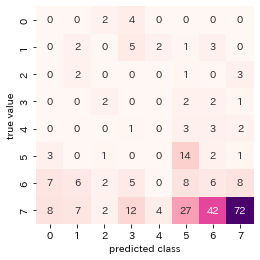

In [133]:
#現状使っているのはこれ
#最初の行の引数が使うデータフレームになっているか確認
#
train_data, test_data = tr.getDataSplitByPeriod(excretion)

## 学習
clf_temp1,y_predict = train(train_data[list_features], test_data[list_features], train_data[target], test_data[target])
X_test_temp = test_data[list_features]
Y_test_temp = test_data[target]

# 推定
Y_predict = clf_temp1.predict(X_test_temp)

# 再現率・適合率・F１値
f1 = classification_report(Y_test_temp, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(f1)

score = accuracy_score(Y_test_temp, Y_predict)
print("score : ", int(((score*100)+0.5)), "%(", score,")")

## ハイパーパラメータの自動最適化
# import optuna
# study = optuna.create_study()
# study.optimize(objective, n_trials = 100)
# study.best_params

#### 結果

## A : 全データで学習・全データで評価

In [ ]:
# コンフュージョンマトリクスをプロットするが思いので、コメントアウトなう

# f1 = classification_report(Y_test_temp, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
# print(f1)
# prf = precision_recall_fscore_support(Y_test_temp, Y_predict, average="macro")
# print('kekka ', round(prf[0]*100, 1), round(prf[1]*100, 1), round(prf[2]*100, 1))
# print(accuracy_score(Y_test_temp, Y_predict))

# cm = confusion_matrix(Y_test_temp, Y_predict)
# plt.figure(figsize = (80, 40))
# sns.heatmap(cm, square=True, annot = True, cmap='Blues')
# plt.show()
# plt.close('all')


## B : 1人ごとに学習・1人ごとに精度

In [ ]:
# テストデータと学習データの分割
RECORD = RECORD.fillna(0)
RECORD['start'] = pd.to_datetime(RECORD['start'])

# 期間でクロスバリテーション
TRAIN_DATA = RECORD[RECORD['start'] < pd.to_datetime('2018-06-15 00:00:00+09:00')]
TEST_DATA = RECORD[pd.to_datetime('2018-06-15 00:00:00+09:00') <= RECORD['start']]
result_human2record = []

for target_id in RECORD['target_id'].value_counts().index:
    
    train_data = TRAIN_DATA[TRAIN_DATA['target_id'] == target_id]
    test_data = TEST_DATA[TEST_DATA['target_id'] == target_id]
    
    # 学習
    clf_temp3 = train(train_data[list_features], test_data[list_features], train_data[target], test_data[target])

    RECORD['start'] = pd.to_datetime(RECORD['start'])
    for act_name in RECORD['act'].value_counts().index.values:
        for record_type_name in RECORD[RECORD['act'] == act_name]['record_type'].value_counts().index.values:
            if len(train_data[train_data['record_type'] == record_type_name]) == 0 or len(test_data[test_data['record_type'] == record_type_name]) == 0:
                continue

            X_test = test_data[test_data['record_type'] == record_type_name][list_features]
            Y_test = test_data[test_data['record_type'] == record_type_name][target]

            print('=======', act_name, '=======')
            print('=======', record_type_name, '=======')
            Y_predict = clf_temp3.predict(X_test)

            # confusion matrix
            cm = confusion_matrix(Y_test, Y_predict)

            # Importance
            importances = importance(clf_temp3, list_features, train_data[list_features])

            # 再現率・適合率・F１値
            f1_repo = classification_report(Y_test, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
            prf = precision_recall_fscore_support(Y_test, Y_predict, average="macro")
            score = accuracy_score(Y_test, Y_predict)
#             print(f1_repo)

            result_human2record.append([act_name, record_type_name, target_id, cm, f1_repo, round(score*100), round(prf[0]*100, 1), round(prf[1]*100, 1), round(prf[2]*100, 1)])

pd.DataFrame(result_human2record, columns = ['act', 'record_type_name', 'target_id', 'cm', 'f1-repo', 'score','precision', 'recall', 'f1']).to_csv(Folder + "/data/result_human2record.csv")

### 結果

In [ ]:
# 平均精度
df = pd.read_csv(Folder + "/data/result_user2record.csv")
print('正答率', df['score'].mean())
print('f1', df['f1'].mean())

## F : 学習曲線

# 特徴量の分析

## 連続変数の相関係数(Pearson Correlation)

['target_id', 'ID_target_role', 'user', 'hour', 'min_day', 'week_day', 'ID_past_value', 'meal_amount_morning', 'meal_amount_lunch', 'meal_amount_dinner', 'meal_amount_snack', 'excretion']


(12.0, 0.0)

Text(0.5, 1.0, '特徴量同士の相関')

Text(0.5, 86.984375, '特徴量')

Text(184.90437500000007, 0.5, '特徴量')

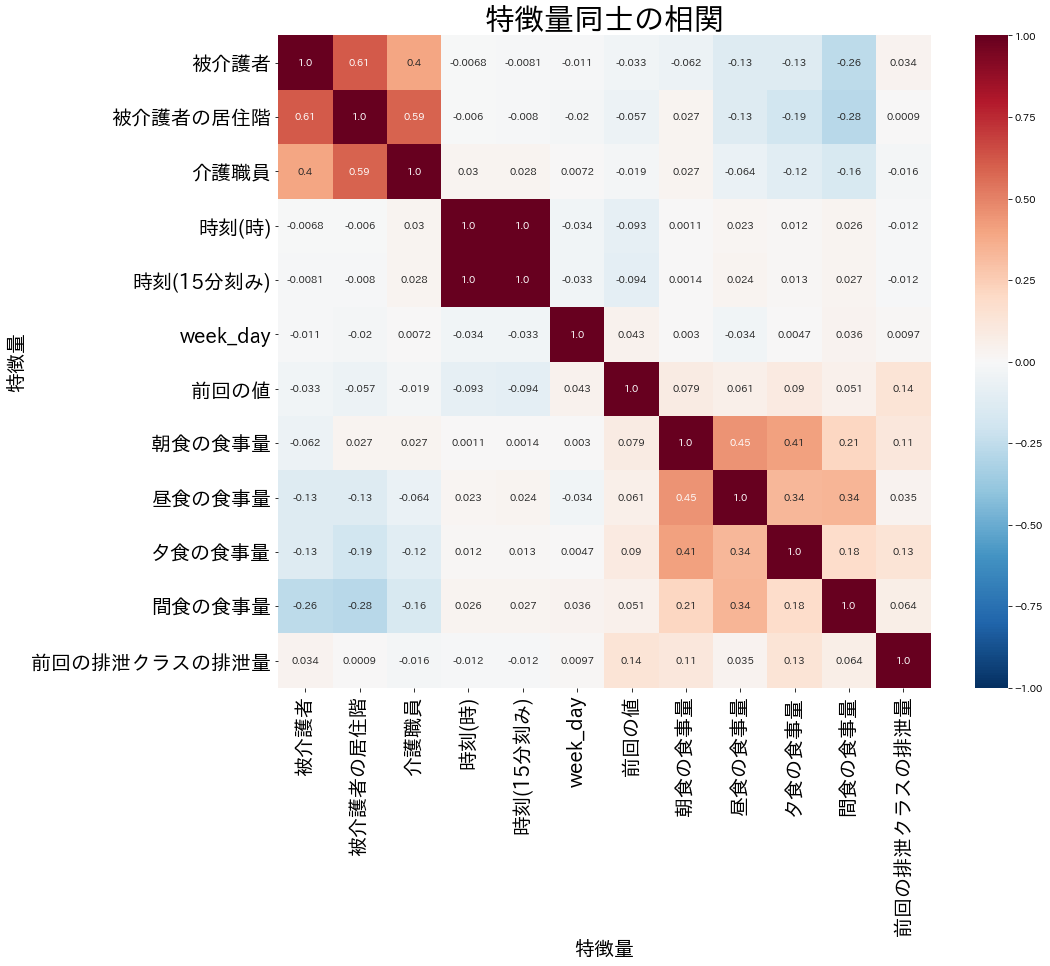

(9.0, 0.0)

Text(0.5, 1.0, 'Correlation of features')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'target_id'),
  Text(1.5, 0, 'ID_target_role'),
  Text(2.5, 0, 'user'),
  Text(3.5, 0, 'hour'),
  Text(4.5, 0, 'min_day'),
  Text(5.5, 0, 'ID_past_value'),
  Text(6.5, 0, 'meal_amount'),
  Text(7.5, 0, 'water'),
  Text(8.5, 0, 'excretion')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'target_id'),
  Text(0, 1.5, 'ID_target_role'),
  Text(0, 2.5, 'user'),
  Text(0, 3.5, 'hour'),
  Text(0, 4.5, 'min_day'),
  Text(0, 5.5, 'ID_past_value'),
  Text(0, 6.5, 'meal_amount'),
  Text(0, 7.5, 'water'),
  Text(0, 8.5, 'excretion')])

Text(0.5, 88.0, 'Features')

Text(185.92000000000007, 0.5, 'Features')

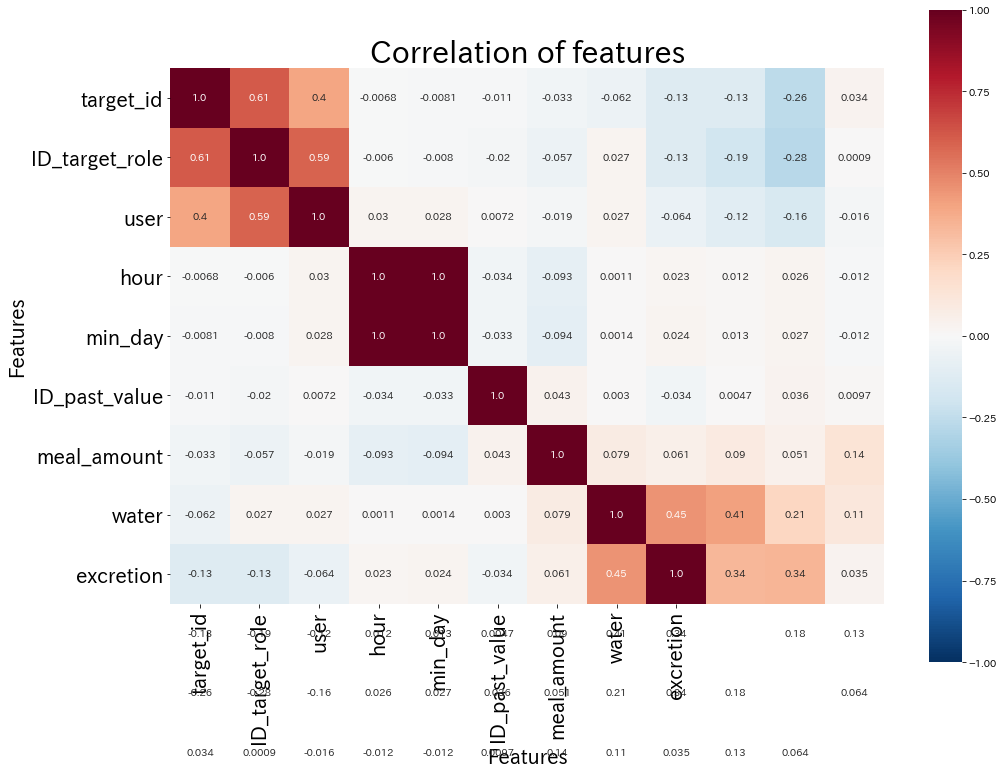

In [16]:
#Pearson Correlation for Continiuos Variables
translate_features_jp = {
    'target_id':'被介護者',
    'ID_target_role':'被介護者の居住階',
    'user':'介護職員',
    'hour':'時刻(時)',
    'min_day':'時刻(15分刻み)',
    'ID_past_value':'前回の値',
    'main_amount':'前回の食事・服薬クラスの主食量',
    'main_amount_morning':'前回の食事・服薬クラスの主食量',
    'main_amount_morning':'前回の食事・服薬クラスの主食量',
    'main_amount_dinner':'前回の食事・服薬クラスの主食量',
    'main_amount_oyatsu':'前回の食事・服薬クラスの主食量',
    'meal_amount':'前回の食事量',
    'sub_amount':'前回の食事・服薬クラスの副食量',
    'sub_amount_morning':'前回の食事・服薬クラスの副食量',
    'sub_amount_lunch':'前回の食事・服薬クラスの副食量',
    'sub_amount_dinner':'前回の食事・服薬クラスの副食量',
    'sub_amount_oyatsu':'前回の食事・服薬クラスの副食量',

    'water':'前回の食事・服薬クラスの水分量',
    'water_morning':'前回の食事・服薬クラスの水分量',
    'water_lunch':'前回の食事・服薬クラスの水分量',
    'water_dinner':'前回の食事・服薬クラスの水分量',
    'water_oyatsu':'前回の食事・服薬クラスの水分量',

    'meal_amount_morning':'朝食の食事量',
    'meal_amount_lunch':'昼食の食事量',
    'meal_amount_dinner':'夕食の食事量',
    'meal_amount_oyatsu':'おやつの食事量',
    'meal_amount_snack':'間食の食事量',

    'excretion':'前回の排泄クラスの排泄量',
}
# continious_features = ['target_id','ID_target_role','user','hour','min_day','ID_past_value','main_amount','sub_amount','water','excretion']
# continious_features = ['target_id','ID_target_role','user','hour','min_day','ID_past_value','meal_amount','water','excretion']
continious_features = list_features
print(continious_features)
features_df = RECORD[continious_features].astype('int32')
tmp = pd.DataFrame(continious_features)
continious_features_jp = list(tmp.replace(translate_features_jp)[0].values)

corr = features_df.corr()
fig, ax = plt.subplots(figsize=fsize)
corr = sns.heatmap(corr, xticklabels=continious_features_jp, yticklabels=continious_features_jp, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, fmt='.2', square=True)
ax.set_ylim(len(continious_features_jp), 0)
plt.title('特徴量同士の相関',fontsize=fsize_title)
plt.xlabel('特徴量',fontsize=fsize_label)
plt.ylabel('特徴量',fontsize=fsize_label)
plt.tick_params(labelsize=fsize_label)
plt.savefig('img/CorrelationOfFeatures', bbox_inches='tight')
plt.show()


# 英語で

# continious_features_en = ['target_id','ID_target_role','user','hour','min_day','ID_past_value','main_amount','sub_amount','water','excretion']
continious_features_en = ['target_id','ID_target_role','user','hour','min_day','ID_past_value','meal_amount','water','excretion']

corr = features_df.corr()
fig, ax = plt.subplots(figsize=fsize)
corr = sns.heatmap(corr, xticklabels=continious_features_en, yticklabels=continious_features_en, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, fmt='.2', square=True)
ax.set_ylim(len(continious_features_en), 0)
plt.title('Correlation of features',fontsize=fsize_title)
plt.xticks(rotation=90, fontsize=fsize_label)
plt.yticks(rotation=0, fontsize=fsize_label)
plt.xlabel('Features',fontsize=fsize_label)
plt.ylabel('Features',fontsize=fsize_label)
plt.tick_params(labelsize=fsize_label)
plt.savefig('img/CorrelationOfFeatures_en', bbox_inches='tight')
plt.show()

# ランダムフォレスト実装用

In [11]:
#追加分
#ランダムフォレストを走らせたあとに実行する
#平均と正答率を出す
def mean_acc(y_predict, test_target):
    count = 0
    miss = 0
    for i in range(len(y_predict)):
        miss = miss + abs(y_predict[i] - test_data[target].iloc[i])
        if y_predict[i] == test_data[target].iloc[i]:
            count = count + 1
    acc = count/len(y_predict) * 100
    mean = miss / len(y_predict)
    print(acc)
    print('この予測に対する平均絶対誤差は' , mean , 'です')

In [ ]:
mean_acc(y_predict, test_data[target])

In [6]:
RECORD = db.getPreprocessedData()
#RECORD = RECORD[RECORD['record_type'].isin(['排尿量','水分量'])]
#RECORD = RECORD[RECORD['record_type'].isin(['排便量','排尿量','食事量','水分量'])]
#test_data = RECORD[pd.to_datetime('2018-06-29 00:00:00+09:00') <= RECORD['start']][RECORD['target_id'].isin([92,36])]
#test_data = test_data.sort_values(by='target_id') 
#test_data = test_data.sort_values(by='start') 
#test_data

c:\users\ucchi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
#探しているcolumnsがデータフレームの何番目にあるか
def columns_num(culumns_name):
    count = 0
    for i in RECORD.columns:
        if i == culumns_name:
            break
        count = count + 1
    return count

In [12]:
#ここから
RECORD = db.getPreprocessedData()
RECORD = RECORD.sort_values(by='start') 
#RECORD

In [5]:
#excretion = RECORD[RECORD['record_type'].isin(['排尿量'])]
RECORD = RECORD[RECORD['target_id'].isin([29,38])]
#RECORD
len(RECORD)

5312

In [10]:
#特定のレコードを排除するメソッド
#データフレームの構造に依存するため、構造が変わる場合に要注意
#現状は同じ時間のレコードは時間予測に影響を及ぼすことが懸念されるためこれメソッドを使用する
record_type = ['排泄介助', '食事介助', '服薬','排泄方法','食事量(副食)','入浴介助']
record_columns = []
for k in range(len(RECORD)):
    if RECORD.iloc[k,6] in record_type:
       record_columns.append(k)

RECORD = RECORD.drop(RECORD.index[[record_columns]])
#RECORD
len(RECORD)

c:\users\ucchi\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexes\base.py:4307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


49756

In [9]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#データフレームのcolum列に依存しているため、データフレームの構造が変わると動かないことに注意
#実行の際はあらかじめ時間順にソートしておくこと!
#過去の排尿量・排便量の時間を知るようのメソッド
def past_hour(RECORD, record_type, a):
    name = []
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
        
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        
    for k in range(len(RECORD)):
        starttime = RECORD.iloc[k,2]
        Target_id = RECORD.iloc[k,10]
        
        if Target_id_time[Target_id] == 0:
            name.append(0)
            #初期値処理
            if RECORD.iloc[k,6] == record_type:
                Target_id_time[Target_id] = starttime
            continue
                
        PastHour = round((starttime - Target_id_time[Target_id])/timedelta(hours=1))
    
        name.append(PastHour)
            
        if RECORD.iloc[k,6] == record_type:
            Target_id_time[Target_id] = starttime
    
    RECORD[a] = name
    

In [10]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#データフレームのcolum列に依存しているため、データフレームの構造が変わると動かないことに注意
#実行の際はあらかじめ時間順にソートしておくこと!
#過去の排便・排尿時間を軸に過去の食事・水分時間を知るメソッド
def past_hour2(RECORD, search_record, flag_record, a):
    name = []
    
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
    Target_id_sub_time = {}
    Target_id_flag = {}    
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        Target_id_sub_time[id[i]] = 0
        Target_id_flag[id[i]] = 1
        
    for k in range(len(RECORD)):
        starttime = RECORD.iloc[k,2]
        Target_id = RECORD.iloc[k,10]
        
        if Target_id_time[Target_id] == 0:
            name.append(0)
            #初期値処理
            if RECORD.iloc[k,6] == search_record:
                Target_id_time[Target_id] = starttime
                Target_id_sub_time[Target_id] = starttime
            continue
                
        PastHour = round((starttime - Target_id_time[Target_id])/timedelta(hours=1))
    
        name.append(PastHour)
        
        
        if RECORD.iloc[k,6] == flag_record:
            Target_id_flag[Target_id] = 1
            Target_id_time[Target_id] = Target_id_sub_time[Target_id]
            
        if RECORD.iloc[k,6] == search_record:
            if Target_id_flag[Target_id] == 1:
                Target_id_time[Target_id] = starttime
                Target_id_sub_time[Target_id] = starttime
                Target_id_flag[Target_id] = 0
                
            elif Target_id_flag[Target_id] == 0:
                Target_id_sub_time[Target_id] = starttime
                
    
    RECORD[a] = name
    

In [11]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#データフレームのcolum列に依存しているため、データフレームの構造が変わると動かないことに注意
#実行の際はあらかじめ時間順にソートしておくこと!
#過去の排便・排尿時間を軸に過去の食事・水分時間を知るメソッド
#past_hour2との違いは水分量や食事量の値が0のときはスキップする仕様にしている。
def past_hour3(RECORD, search_record, flag_record, a):
    name = []
    
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
    Target_id_sub_time = {}
    Target_id_flag = {}    
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        Target_id_sub_time[id[i]] = 0
        Target_id_flag[id[i]] = 1
        
    for k in range(len(RECORD)):
        starttime = RECORD.iloc[k,2]
        Target_id = RECORD.iloc[k,10]
        
        if Target_id_time[Target_id] == 0:
            name.append(0)
            #初期値処理
            if RECORD.iloc[k,6] == search_record:
                Target_id_time[Target_id] = starttime
                Target_id_sub_time[Target_id] = starttime
            continue
                
        PastHour = round((starttime - Target_id_time[Target_id])/timedelta(hours=1))
    
        name.append(PastHour)
        
        
        if RECORD.iloc[k,6] == flag_record:
            Target_id_flag[Target_id] = 1
            Target_id_time[Target_id] = Target_id_sub_time[Target_id]
            
        if RECORD.iloc[k,6] == search_record:
            if RECORD.iloc[k,7] == '0':
                continue
                
            if Target_id_flag[Target_id] == 1:
                Target_id_time[Target_id] = starttime
                Target_id_sub_time[Target_id] = starttime
                Target_id_flag[Target_id] = 0
                
            elif Target_id_flag[Target_id] == 0:
                Target_id_sub_time[Target_id] = starttime
                
    
    RECORD[a] = name
    

In [12]:
past_water_hour = []
past_hour3(RECORD, '水分量', '排尿量', 'past_water_hour')

past_meal_hour = []
past_hour3(RECORD, '食事量(主食)', '排便量', 'past_meal_hour')

past_urination_hour = []
past_hour(RECORD, '排尿量', 'past_uri_hour')

past_excretion_hour = []
past_hour(RECORD, '排便量', 'past_exc_hour')

In [13]:
#未来のレコードまであとどのくらいの時間があるのかという配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#現在は排泄予測に用いている。6時間以降は6,12時間以降は12、24時間以降は24の値を入れている。
#データフレームのcolum列に依存しているため、データフレームの構造が変わると動かないことに注意
#実行の際はあらかじめ時間順を逆にソートしておくこと!
#排尿量と水分量だけのデータフレームにする→この関数を動かす→排尿量だけのデータフレームにする→学習
def future_hour(RECORD, record_type, a):
    FutureHour = 0
    name = []
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        
    
    
    for k in range(len(RECORD)):
        starttime = RECORD.iloc[k,2]
        Target_id = RECORD.iloc[k,10]
        #初期値処理
        if Target_id_time[Target_id] == 0:
            name.append(0)
            
            if RECORD.iloc[k,6] == record_type:
                Target_id_time[Target_id] = starttime
            continue
        
        #必要に応じてroundを使う
        #FutureHour = round((Target_id_time[Target_id] - starttime)/timedelta(hours=1))
        FutureHour = (Target_id_time[Target_id] - starttime)/timedelta(hours=1)
        
        #24時間以降は1日単位で時間を表す処理
        #if 6<= FutureHour < 12:
            #FutureHour = 6
        #elif 12<= FutureHour < 24:
            #FutureHour = 12
        #elif FutureHour >= 24:
            #FutureHour = 24
            
        name.append(FutureHour)
            
        if RECORD.iloc[k,6] == record_type:
            Target_id_time[Target_id] = starttime
        
    RECORD[a] = name

In [14]:
RECORD_re = RECORD.sort_values(by='start', ascending=False) 
#RECORD_re

In [15]:
future_urination_hour = []
future_hour(RECORD_re, '排尿量', 'future_uri_hour')
future_excretion_hour = []
future_hour(RECORD_re, '排便量', 'future_exc_hour')

In [16]:
RECORD = RECORD_re.sort_values(by='start') 

In [71]:
excretion = RECORD[RECORD['target_id'].isin([29])]
#excretion = excretion[excretion['future_urination_hour'] != 0]
#excretion = excretion[excretion['future_excretion_hour'] != 0]
excretion

id date                     start                    finish                created_at                updated_at record_type      value  user         act  target_id target_role  \
6154   130492   01 2018-05-01 14:45:52+09:00 2018-05-01 14:48:59+09:00 2018-04-30 14:48:58+09:00 2018-04-30 14:48:58+09:00        入浴方法        一般浴     2       入浴・清拭         29          ２階   
6162   130522   01 2018-05-01 15:20:40+09:00 2018-05-01 15:20:42+09:00 2018-04-30 15:20:48+09:00 2018-04-30 15:20:48+09:00        入浴方法        一般浴     2       入浴・清拭         29          ２階   
8243   130765   01 2018-05-01 18:53:50+09:00 2018-05-01 18:53:54+09:00 2018-04-30 18:53:50+09:00 2018-04-30 18:53:50+09:00         水分量        300     6       食事・服薬         29          ２階   
8241   130763   01 2018-05-01 18:53:50+09:00 2018-05-01 18:53:54+09:00 2018-04-30 18:53:49+09:00 2018-04-30 18:53:49+09:00     食事量(主食)         10     6       食事・服薬         29          ２階   
3829   126883   01 2018-05-02 01:40:55+09:00 2018-05-02 01:41:13+09:00 2018-04-30 01:41:12+09:00 2018-04-30 01:41:12+09:00         排尿量         中量     8          排泄         29          ２階   
3841   126931   01 2018-05-02 03:39:39+09:00 2018-05-02 03:40:05+09:00 2018-04-30 03:40:04+09:00 2018-04-30 03:40:04+09:00         排尿量         多量     8          排泄         29          ２階   
3844   127086   01 2018-05-02 07:26:42+09:00 2018-05-02 07:28:40+09:00 2018-04-30 07:28:37+09:00 2018-04-30 07:28:37+09:00         排尿量         中量     8          排泄         29          ２階   
3845   127087   01 2018-05-02 07:26:42+09:00 2018-05-02 07:28:40+09:00 2018-04-30 07:28:37+09:00 2018-04-30 07:28:37+09:00         排便量         多量     8          排泄         29          ２階   
3846   127088   01 2018-05-02 07:26:42+09:00 2018-05-02 07:28:40+09:00 2018-04-30 07:28:37+09:00 2018-04-30 07:28:37+09:00        便の状態        水様便     8          排泄         29          ２階   
6483   126356   01 2018-05-02 08:22:48+09:00 2018-05-02 08:22:49+09:00 2018-04-29 15:23:03+09:00 2018-04-29 15:23:03+09:00     食事量(主食)          0     2       食事・服薬         29          ２階   
6485   126358   01 2018-05-02 08:22:48+09:00 2018-05-02 08:22:49+09:00 2018-04-29 15:23:03+09:00 2018-04-29 15:23:03+09:00         水分量          0     2       食事・服薬         29          ２階   
21417  150912   01 2018-05-02 08:30:09+09:00 2018-05-01 09:05:37+09:00 2018-05-03 08:32:31+09:00 2018-05-03 08:32:31+09:00       ラジオ体操         参加     2  活力朝礼・ラジオ体操         29          ２階   
21416  150864   01 2018-05-02 08:30:09+09:00 2018-05-01 09:05:37+09:00 2018-05-03 08:32:28+09:00 2018-05-03 08:32:28+09:00        活力朝礼         参加     2  活力朝礼・ラジオ体操         29          ２階   
8286   132318   02 2018-05-02 09:30:00+09:00 2018-05-02 10:38:00+09:00 2018-05-01 08:38:19+09:00 2018-05-01 08:38:19+09:00     食事量(主食)         10     6       食事・服薬         29          ２階   
8288   132320   02 2018-05-02 09:30:00+09:00 2018-05-02 10:38:00+09:00 2018-05-01 08:38:19+09:00 2018-05-01 08:38:19+09:00         水分量        300     6       食事・服薬         29          ２階   
19770  132985   02 2018-05-02 10:35:07+09:00 2018-05-02 10:35:08+09:00 2018-05-01 10:41:47+09:00 2018-05-01 10:41:47+09:00        対応内容     利用者の様子     5     日中利用者対応         29          ２階   
19769  132984   02 2018-05-02 10:35:07+09:00 2018-05-02 10:35:08+09:00 2018-05-01 10:41:47+09:00 2018-05-01 10:41:47+09:00          種別       定期記録     5     日中利用者対応         29          ２階   
428    132990   02 2018-05-02 10:38:21+09:00 2018-05-02 10:38:22+09:00 2018-05-01 10:42:04+09:00 2018-05-01 10:42:04+09:00         排尿量         中量     5          排泄         29          ２階   
6856   133490   02 2018-05-02 12:05:59+09:00 2018-05-02 12:36:00+09:00 2018-05-01 13:04:53+09:00 2018-05-01 13:04:53+09:00         水分量        200     5       食事・服薬         29          ２階   
6854   133488   02 2018-05-02 12:05:59+09:00 2018-05-02 12:36:00+09:00 2018-05-01 13:04:53+09:00 2018-05-01 13:04:53+09:00     食事量(主食)         10     5       食事・服薬         29          ２階   
431    133331   02 20

In [32]:
#レコードの起こった時間(開始)時間帯を棒グラフとして出力する
#

def hour_bar(RECORD, record_type, target):
    RECORD = RECORD[RECORD['record_type'] == record_type]
    RECORD = RECORD[RECORD['target_id'].isin(target)]
    hour = RECORD['hour']
    hour = hour.values
    count = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    hour_time = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
    
    for i in hour:
        count[i] = count[i] + 1
    plt.bar(hour_time,count)

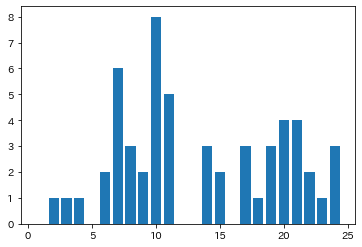

In [48]:
hour_bar(excretion, '排便量' , [29])

In [23]:
#排尿量のための特徴量
list_features = [
#     'ID_act', 'ID_record_type',
    #'target_id',
    #'ID_target_role',
    #'user',
    'hour',
    #'min_day',
    #'week_day',
    #'ID_past_value',

    'past_water_hour',
    'past_urination_hour'
    
]

target = 'future_urination_hour'

In [ ]:
#排便量のための特徴量
list_features = [
#     'ID_act', 'ID_record_type',
    #'target_id',
    #'ID_target_role',
    #'user',
    'hour',
    #'min_day',
    #'week_day',
    #'ID_past_value',  
    'past_meal_hour',
    'past_excretion_hour'
    
]

target = 'future_excretion_hour'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           1       0.26      0.35      0.30        71
           2       0.28      0.33      0.30        91
           3       0.22      0.17      0.19       105
           4       0.17      0.17      0.17        40
           5       0.24      0.14      0.18        28
           6       0.09      0.14      0.11        58
          12       0.00      0.00      0.00        46

    accuracy                           0.21       439
   macro avg       0.18      0.19      0.18       439
weighted avg       0.19      0.21      0.20       439

score :  21 %( 0.20956719817767655 )


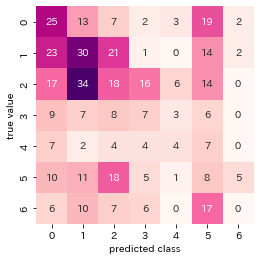

In [24]:
#現状使っているのはこれ
#最初の行の引数が使うデータフレームになっているか確認
#
train_data, test_data = tr.getDataSplitByPeriod(excretion)

## 学習
clf_temp1,y_predict = train(train_data[list_features], test_data[list_features], train_data[target], test_data[target])
X_test_temp = test_data[list_features]
Y_test_temp = test_data[target]

# 推定
Y_predict = clf_temp1.predict(X_test_temp)

# 再現率・適合率・F１値
f1 = classification_report(Y_test_temp, Y_predict, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(f1)

score = accuracy_score(Y_test_temp, Y_predict)
print("score : ", int(((score*100)+0.5)), "%(", score,")")

## ハイパーパラメータの自動最適化
# import optuna
# study = optuna.create_study()
# study.optimize(objective, n_trials = 100)
# study.best_params

# ここから斎藤先生ランダムフォレスト

In [17]:
excretion = RECORD[RECORD['record_type'].isin(["対応内容", "水分量", '排尿量', "食事量(主食)", "処置内容", "口腔内清掃",  "入浴方法", "排便量"])]

In [18]:
excretion = excretion[excretion['target_id'].isin([29,31,35,36,38,40,43,44,45,48,53,59,61])]

In [8]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#過去の排尿量・排便量の時間を知るようのメソッド
def past_hour(RECORD, a, b, c):
    
    
    flag = [] #bの時間以内に介護レコードがあるかどうか
    Bath_Time = []
    Drink_Time = []
    Amount_Water = []
    Meal_Time = []
    Urine_Time = []
    Def_Time = []
    
    start_colum_num = columns_num("start")
    value_colum_num = columns_num("value")
    Target_colum_num = columns_num("target_id")
    
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
        
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        
    for k in range(len(RECORD)):
        sum_water = 0
        
        Target_id = RECORD.iloc[k,Target_colum_num]
        RECORD_id = RECORD[RECORD['target_id'].isin([Target_id])]
        
        
        Target_id_time[Target_id] = Target_id_time[Target_id] + 1
        
        
        start_time = RECORD.iloc[k,start_colum_num]
        Consider_Time = start_time - dt.timedelta(hours = b)
        past_Data = RECORD_id[RECORD_id['start'] < start_time]
        Consider_Data = past_Data[past_Data['start'] > Consider_Time]
        
        if len(Consider_Data) == 0 or Target_id_time[Target_id] == 1:
            flag.append(False)
            Bath_Time.append(0)
            Drink_Time.append(0)
            Amount_Water.append(0)
            Meal_Time.append(0)
            Urine_Time.append(0)
            Def_Time.append(0)
            
        else:
            flag.append(True)
            s_bool = Consider_Data['record_type'] == "入浴方法"
            Bath_Time.append(s_bool.sum())
            s_bool = Consider_Data['record_type'] == "食事量(主食)"
            Meal_Time.append(s_bool.sum())
            s_bool = Consider_Data['record_type'] == "排尿量"
            Urine_Time.append(s_bool.sum())
            s_bool = Consider_Data['record_type'] == "排便量"
            Def_Time.append(s_bool.sum())
            
            
            RECORD_id_water = Consider_Data[Consider_Data['record_type'].isin(["水分量"])]
            Drink_Time.append(len(RECORD_id_water))
                                                                     
            for j in range(len(RECORD_id_water)):
                sum_water = sum_water + int(RECORD_id_water.iloc[j,value_colum_num])
            Amount_Water.append(sum_water)
            
     
    RECORD["feature_flag"] = flag
    RECORD["Bath_Time"] = Bath_Time
    RECORD["Drink_Time"] = Drink_Time
    RECORD["Amount_Water"] = Amount_Water
    RECORD["Meal_Time"] = Meal_Time
    RECORD["Urine_Time"] = Urine_Time
    RECORD["Def_Time"] = Def_Time
    

In [9]:
past_hour(excretion, 0, 2, 0)

In [10]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#過去の排尿量・排便量の時間を知るようのメソッド
def urine_nonurine(RECORD):
    
    
    urine_nonurine = [] 
    
    record_colum_num = columns_num("record_type")
    
    for k in range(len(RECORD)):
        if  RECORD.iloc[k,record_colum_num] == "排尿量":
            urine_nonurine.append(1)
        else:
            urine_nonurine.append(0)
    
    RECORD["urine_nonurine"] = urine_nonurine
 


In [11]:
urine_nonurine(excretion)

In [12]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#過去の排尿量・排便量の時間を知るようのメソッド
def def_nondef(RECORD):
    
    
    def_nondef = [] 
    
    record_colum_num = columns_num("record_type")
    
    for k in range(len(RECORD)):
        if  RECORD.iloc[k,record_colum_num] == "排便量":
            def_nondef.append(1)
        else:
            def_nondef.append(0)
    
    RECORD["def_nondef"] = def_nondef
 


In [13]:
def_nondef(excretion)

In [16]:
#排尿量のための特徴量
list_features = [
#     'ID_act', 'ID_record_type',
    #'target_id',
    #'ID_target_role',
    #'user',
    #'hour',
    'min_day',
    #'week_day',
    #'ID_past_value',
    "Bath_Time",
    "Drink_Time",
    "Amount_Water",
    "Meal_Time",
    "Urine_Time",
    "Def_Time"
    
    
]

target = 'urine_nonurine'

In [ ]:
#排便量のための特徴量
list_features = [
#     'ID_act', 'ID_record_type',
    #'target_id',
    #'ID_target_role',
    #'user',
    'hour',
    #'min_day',
    #'week_day',
    #'ID_past_value',  
    'past_meal_hour',
    'past_excretion_hour',
    "Meal_Time"
    
]

target = 'future_excretion_hour'

In [33]:
uri_data = excretion[excretion["feature_flag"] ==True]

In [40]:
def confusionmatrix(y_test, y_predict):
    mat = confusion_matrix(y_test, y_predict)
    sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
    plt.xlabel('predicted class')
    plt.ylabel('true value')

Cross Validation ( Iter = 4 )
-> Train data size : 503
-> Test data size  : 168
------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  k=0: 0.7083333333333334


[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished


RandomForestClassifier(max_depth=200, n_estimators=700, random_state=10,
                       verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       120
           1       0.49      0.54      0.51        48

    accuracy                           0.71       168
   macro avg       0.65      0.66      0.65       168
weighted avg       0.72      0.71      0.71       168

score :  71 %( 0.7083333333333334 )
[0.6570493  0.0218593  0.03575767 0.08781054 0.03128807 0.12459175
 0.04164337]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  k=1: 0.6785714285714286


[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished


RandomForestClassifier(max_depth=200, n_estimators=700, random_state=10,
                       verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.72      0.80      0.76       107
           1       0.57      0.46      0.51        61

    accuracy                           0.68       168
   macro avg       0.65      0.63      0.64       168
weighted avg       0.67      0.68      0.67       168

score :  68 %( 0.6785714285714286 )
[0.67781454 0.0182344  0.0260431  0.09363341 0.0225379  0.12683346
 0.03490317]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished


  k=2: 0.7261904761904762


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished


RandomForestClassifier(max_depth=200, n_estimators=700, random_state=10,
                       verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.85      0.74      0.79       118
           1       0.53      0.70      0.60        50

    accuracy                           0.73       168
   macro avg       0.69      0.72      0.70       168
weighted avg       0.76      0.73      0.74       168

score :  73 %( 0.7261904761904762 )
[0.66187388 0.01943658 0.02935789 0.08249856 0.0250209  0.14786224
 0.03394996]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  k=3: 0.7065868263473054


[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.4s finished


RandomForestClassifier(max_depth=200, n_estimators=700, random_state=10,
                       verbose=True)

              precision    recall  f1-score   support

           0       0.74      0.83      0.79       108
           1       0.61      0.47      0.53        59

    accuracy                           0.71       167
   macro avg       0.68      0.65      0.66       167
weighted avg       0.70      0.71      0.70       167

score :  71 %( 0.7065868263473054 )
[0.68324836 0.02533955 0.02370339 0.08404415 0.02056353 0.12275634
 0.04034467]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.0s finished


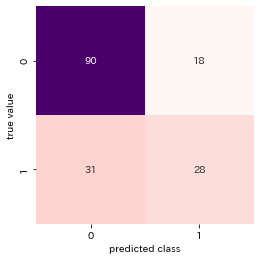

In [44]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris

if __name__ == '__main__':

    uri = uri_data[uri_data['target_id'].isin([31])]
    
    iter = 4 # 実施する交差検証の回数を指定
    test_size = float(1) / iter # テストに用いるデータの比率を指定

    # 実験用データセットの読み込み
    parms = {'n_estimators':700 ,'max_depth':200, 'verbose':True}
    
    x = uri[list_features]
    x = x.to_numpy()
    y = uri[target]
    y = y.to_numpy()

    # k-分割交差検証の実施
    print('Cross Validation ( Iter = {0} )'.format(iter))
    print('-> Train data size : {:.0f}'.format(len(x) - test_size * len(x)))
    print('-> Test data size  : {:.0f}'.format(len(x) * test_size))
    print('------------------------')

    i = 0
    kf = KFold(n_splits=iter, shuffle=True, random_state=0)
    clf_ = RandomForestClassifier(random_state=10, n_estimators=parms['n_estimators'] , max_depth=parms['max_depth'], verbose=parms['verbose'])
    for train_i, test_i in kf.split(x):
        train_x, test_x = x[train_i], x[test_i]
        train_y, test_y = y[train_i], y[test_i]
        clf = clf_.fit(train_x, train_y)
        print('  k={0}: {1}'.format(i, clf.score(test_x, test_y)))
        
        clf_.fit(train_x, train_y)
        predict_y = clf_.predict(test_x)
        f1 = classification_report(test_y, predict_y, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
        print(f1)
        
        score = accuracy_score(test_y, predict_y)
        print("score : ", int(((score*100)+0.5)), "%(", score,")")
        print(clf_.feature_importances_)
        
        i += 1
    confusionmatrix(test_y, predict_y)

# 便利コマンド 

In [26]:
#データフレームの特定の行の要素を配列として出力する
target_id = set(RECORD['target_id'])
target_id = list(target_id)
target_id
len(target_id)

[29,
 30,
 31,
 32,
 33,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 48,
 49,
 50,
 53,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 65,
 67,
 68,
 71,
 72,
 73,
 74,
 75,
 77,
 79,
 84,
 85,
 88,
 89,
 92,
 95,
 98,
 110,
 120]

45

In [33]:
for j in excretion.columns:
    print(j)    

id
date
start
finish
created_at
updated_at
record_type
value
user
act
target_id
target_role
activity2user_id
act_id
year
month
year-month-date
ID_act
ID_record_type
ID_value
ID_target_role
hour
min_day
year-month-date-hour
ID_past_value
main_amount
sub_amount
excretion
water
is_morning
is_lunch
is_dinner
is_oyatsu
is_snack
main_amount_morning
main_amount_lunch
main_amount_dinner
main_amount_oyatsu
main_amount_snack
sub_amount_morning
sub_amount_lunch
sub_amount_dinner
sub_amount_oyatsu
sub_amount_snack
water_morning
water_lunch
water_dinner
water_oyatsu
water_snack
past_value
meal_amount
meal_amount_morning
meal_amount_lunch
meal_amount_dinner
meal_amount_oyatsu
meal_amount_snack
week_day
past_water_hour
past_meal_hour
past_uri_hour
past_exc_hour
future_uri_hour
future_exc_hour
U_17


In [21]:
#探しているcolumnsがデータフレームの何番目にあるか
def columns_num(culumns_name):
    count = 0
    for i in excretion.columns:
        if i == culumns_name:
            break
        count = count + 1
    return count

In [68]:
#3時間以内に排泄があるかどうか
def excretion_time(RECORD, future_record, a):
    name = []
    
    colum_num = RECORD.columns.get_loc(future_record) 
        
    for k in range(len(RECORD)):
        if RECORD.iloc[k,colum_num] > 3:
            name.append('No')
        else:
            name.append('Yes')
    
            
    RECORD[a] = name
    
    

In [69]:
excretion_time(RECORD, 'future_uri_hour', 'uri_time')

In [ ]:
excretion_time(RECORD, 'future_uri_hour', 'uri_time')

In [67]:
hour = list(RECORD['past_excretion_minute'])
hour2 = []
for i in hour:
    if i%60 > 30:
        hour2.append((i//60) + 1)
    else:
        hour2.append(i//60)
RECORD['past_excretion_hour'] = hour2

In [ ]:
excretion = excretion.drop(['past_water_minute','past_urination_minute','past_excretion_minute','past_meal_minute'], axis=1)
excretion

In [4]:
#excretion = RECORD[RECORD['record_type'].isin(['排尿量'])]
#excretion = RECORD_re[RECORD_re['target_id'].isin([35])]
#excretion = excretion.sort_values(by='start') 
#excretion = excretion[excretion['future_urination_hour'] != 0]
#excretion = excretion[excretion['future_excretion_hour'] != 0]
#excretion

In [ ]:
#現在のレコードの時間が朝か昼かなどの情報をデータフレームに加えるメソッド
#説明変数として加えようと思ったが今は不要か
def day_night(RECORD):
    DayNight = []
    for k in range(len(RECORD)):
        starthour = RECORD.iloc[k,21]
        if 5 <=starthour <= 10:
            period = '朝'
        elif 11 <=starthour <= 14:
            period = '昼'
        elif 15 <=starthour <= 17:
            period = '夕'
        else:
            period = '夜'
        DayNight.append(period)
    RECORD['Day_night'] = DayNight
    #print(DayNight)

In [ ]:
day_night(RECORD)

In [ ]:
uri_value = []
uri = 0
for k in range(len(RECORD)):
    if RECORD.iloc[k,6] == '排尿量':
        if RECORD.iloc[k,7] == '少量':
            uri = 100
        elif RECORD.iloc[k,7] == '中量':
            uri = 200
        elif RECORD.iloc[k,7] == '多量':
            uri = 300
        else:
            uri = 200
    else:
       uri = 0
    
    uri_value.append(uri)

RECORD['uri_value'] = uri_value

In [35]:
excretion = excretion[pd.to_datetime('2018-06-29 00:00:00+09:00') <= excretion['start']][excretion['target_id'].isin([92,36])]

<ipython-input-35-a4b09503f3be>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  excretion = excretion[pd.to_datetime('2018-06-29 00:00:00+09:00') <= excretion['start']][excretion['target_id'].isin([92,36])]


In [ ]:
RECORD['hour'] = RECORD['start'].dt.hour
RECORD['min_day'] = (RECORD['start'].dt.hour*60) + RECORD['start'].dt.minute
RECORD['year-month-date-hour'] = RECORD['year'] + '-'+ RECORD['month'] + '-' + RECORD['date'] + '-' + RECORD['hour'].astype('str').str.zfill(2)

In [ ]:
for i in range(len(RECORD.columns)):
    RECORD.iloc[0,i]

# メソッドの墓場

In [ ]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#データフレームのcolum列に依存しているため、データフレームの構造が変わると動かないことに注意
#実行の際はあらかじめ時間順にソートしておくこと!
#排尿量と水分量だけのデータフレームにする→この関数を動かす→排尿量だけのデータフレームにする→学習
def past_minute(RECORD, record_type, a):
    Minute = 0
    Day = 0
    name = []
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_minute = {}
    for i in range(len(id)):
        Target_id_minute[id[i]] = 0
        
    Target_id_day = {}
    for j in range(len(id)):
        Target_id_day[id[j]] = 0
    
    
    for k in range(len(RECORD)):
        starttime = RECORD.iloc[k,2]
        Target_id = RECORD.iloc[k,10]
        #初期値処理
        if Target_id_minute[Target_id] == 0:
            name.append(round(starttime.hour*60+starttime.minute,-1))
            Target_id_day[Target_id] = starttime.day
            if RECORD.iloc[k,6] == record_type:
                Target_id_minute[Target_id] = round(starttime.hour*60+starttime.minute,-1)
            continue
        
        if starttime.day != Target_id_day[Target_id]:
            name.append(round(starttime.hour*60+starttime.minute + 1440 - Target_id_minute[Target_id],-1))
        else:
            name.append(round(starttime.hour*60+starttime.minute - Target_id_minute[Target_id],-1))
            
        if RECORD.iloc[k,6] == record_type:
            Target_id_minute[Target_id] = round(starttime.hour*60+starttime.minute,-1)
            Target_id_day[Target_id] = starttime.day
        #print(Target_id_minute)
        #print(Target_id_day)
    #print(name)
    RECORD[a] = name

In [ ]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#データフレームのcolum列に依存しているため、データフレームの構造が変わると動かないことに注意
#実行の際はあらかじめ時間順にソートしておくこと!
#過去の排便・排尿時間を軸に過去の食事・水分時間を知るメソッド
def past_hour2(RECORD, search_record, flag_record, a):
    name = []
    
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
    Target_id_sub_time = {}
    Target_id_flag = {}    
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        Target_id_sub_time[id[i]] = 0
        Target_id_flag[id[i]] = 1
        
    for k in range(len(RECORD)):
        starttime = RECORD.iloc[k,2]
        Target_id = RECORD.iloc[k,10]
        
        if Target_id_time[Target_id] == 0:
            name.append(0)
            #初期値処理
            if RECORD.iloc[k,6] == search_record:
                Target_id_time[Target_id] = starttime
                Target_id_sub_time[Target_id] = starttime
            continue
                
        PastHour = round((starttime - Target_id_time[Target_id])/timedelta(hours=1))
    
        name.append(PastHour)
        
        
        if RECORD.iloc[k,6] == flag_record:
            Target_id_flag[Target_id] = 1
            Target_id_time[Target_id] = Target_id_sub_time[Target_id]
            
        if RECORD.iloc[k,6] == search_record:
            if Target_id_flag[Target_id] == 1:
                Target_id_time[Target_id] = starttime
                Target_id_sub_time[Target_id] = starttime
                Target_id_flag[Target_id] = 0
                
            elif Target_id_flag[Target_id] == 0:
                Target_id_sub_time[Target_id] = starttime
                
    
    RECORD[a] = name
    

# 遊ぶよう

In [78]:
#水分量の平均を求めるメソッド
#日付は合計で62日間
def water_mean(target_id):    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    water = {}
    
    r = columns_num('record_type')
    v = columns_num('value')
    t = columns_num('target_id')
    
    for i in range(len(id)):
        water[id[i]] = 0
       
    for k in range(len(RECORD)):
        Target_id = RECORD.iloc[k,t]
  
        if RECORD.iloc[k,r] == '水分量':
            drink = int(RECORD.iloc[k,v])
            #water[Target_id]には'target_id'ごとの水分量の合計が入っている
            water[Target_id] = water[Target_id] + drink
    
    water_mean = water[target_id] / 62
    return water_mean
            
   

In [80]:
water_mean(29)

684.6774193548387

In [10]:
excretion = RECORD[RECORD['record_type'].isin(["水分量", '排尿量', "食事量(主食)", "食事量(副食)", "入浴方法", "排便量"])]

In [38]:
excretion = excretion[excretion['target_id'].isin([29,31])]

In [13]:
a = np.nan

In [14]:
a

nan

In [46]:
b = 2
excretion.iloc[8,2]
a = excretion.iloc[8,2] - dt.timedelta(hours = b)
a
c = excretion[excretion['start'] < excretion.iloc[8,2]]
d = c[c['start'] > a]
c
d

Timestamp('2018-05-02 01:40:55+0900', tz='pytz.FixedOffset(540)')

Timestamp('2018-05-01 23:40:55+0900', tz='pytz.FixedOffset(540)')

id date                     start                    finish                created_at                updated_at record_type value  user    act  target_id target_role  activity2user_id  \
6146  130333   01 2018-05-01 12:20:30+09:00 2018-05-01 12:20:38+09:00 2018-04-30 12:19:26+09:00 2018-04-30 12:19:26+09:00        入浴方法   一般浴     2  入浴・清拭         31          ２階             39541   
6154  130492   01 2018-05-01 14:45:52+09:00 2018-05-01 14:48:59+09:00 2018-04-30 14:48:58+09:00 2018-04-30 14:48:58+09:00        入浴方法   一般浴     2  入浴・清拭         29          ２階             39589   
6162  130522   01 2018-05-01 15:20:40+09:00 2018-05-01 15:20:42+09:00 2018-04-30 15:20:48+09:00 2018-04-30 15:20:48+09:00        入浴方法   一般浴     2  入浴・清拭         29          ２階             39608   
8242  130764   01 2018-05-01 18:53:50+09:00 2018-05-01 18:53:54+09:00 2018-04-30 18:53:49+09:00 2018-04-30 18:53:49+09:00     食事量(副食)    10     6  食事・服薬         29          ２階             39671   
8252  130778   01 2018-05-01 18:53:50+09:00 2018-05-01 18:53:54+09:00 2018-04-30 18:53:50+09:00 2018-04-30 18:53:50+09:00     食事量(副食)     8     6  食事・服薬         31          ２階             39673   
8251  130777   01 2018-05-01 18:53:50+09:00 2018-05-01 18:53:54+09:00 2018-04-30 18:53:50+09:00 2018-04-30 18:53:50+09:00     食事量(主食)    10     6  食事・服薬         31          ２階             39673   
8241  130763   01 2018-05-01 18:53:50+09:00 2018-05-01 18:53:54+09:00 2018-04-30 18:53:49+09:00 2018-04-30 18:53:49+09:00     食事量(主食)    10     6  食事・服薬         29          ２階             39671   
3826  126867   01 2018-05-02 01:00:30+09:00 2018-05-02 01:00:52+09:00 2018-04-30 01:00:51+09:00 2018-04-30 01:00:51+09:00         排尿量    中量     8     排泄         31          ２階             39318   

      act_id  year month year-month-date  ID_act  ID_record_type  ID_value  ID_target_role  hour  min_day year-month-date-hour  ID_past_value  main_amount  sub_amount  excretion  water  is_morning  \
6146    9657  2018    05      2018-05-01       6              15        41               2    12      735        2018-05-01-12            -10          -10         -10        -10    -10       False   
6154    9671  2018    05      2018-05-01       6              15        41               2    14      885        2018-05-01-14            -10          -10         -10        -10    -10       False   
6162    9675  2018    05      2018-05-01       6              15        41               2    15      915        2018-05-01-15             41          -10         -10        -10    -10       False   
8242    9711  2018    05      2018-05-01       1               4        11               2    18     1125        2018-05-01-18            -10          -10         -10        -10    -10       False   
8252    9711  2018    05      2018-05-01       1               4         9               2    18     1125        2018-05-01-18            -10          -10         -10        -10    -10       False   
8251    9711  2018    05      2018-05-01       1               3        11               2    18     1125        2018-05-01-18            -10          -10         -10        -10    -10       False   
8241    9711  2018    05      2018-05-01       1               3        11               2    18     1125        2018-05-01-18            -10          -10         -10        -10    -10       False   
3826    9580  2018    05      2018-05-01       2              10        28               2     1       60        2018-05-01-01            -10           11           9        -10      7       False   

      is_lunch  is_dinner  is_oyatsu is_snack  main_amount_morning  main_amount_lunch  main_amount_dinner  main_amount_oyatsu  main_amount_snack  sub_amount_morning  sub_amount_lunch  \
6146     False      False      False      NaN                  -10                -10                 -10                 -10                -10                 -10               -10   
6154     False      False      False      NaN                  

id date                     start                    finish                created_at                updated_at record_type value  user act  target_id target_role  activity2user_id  \
3826  126867   01 2018-05-02 01:00:30+09:00 2018-05-02 01:00:52+09:00 2018-04-30 01:00:51+09:00 2018-04-30 01:00:51+09:00         排尿量    中量     8  排泄         31          ２階             39318   

      act_id  year month year-month-date  ID_act  ID_record_type  ID_value  ID_target_role  hour  min_day year-month-date-hour  ID_past_value  main_amount  sub_amount  excretion  water  is_morning  \
3826    9580  2018    05      2018-05-01       2              10        28               2     1       60        2018-05-01-01            -10           11           9        -10      7       False   

      is_lunch  is_dinner  is_oyatsu is_snack  main_amount_morning  main_amount_lunch  main_amount_dinner  main_amount_oyatsu  main_amount_snack  sub_amount_morning  sub_amount_lunch  \
3826     False      False      False      NaN                  -10                -10                  11                 -10                -10                 -10               -10   

      sub_amount_dinner  sub_amount_oyatsu  sub_amount_snack  water_morning  water_lunch  water_dinner  water_oyatsu  water_snack past_value  meal_amount  meal_amount_morning  meal_amount_lunch  \
3826                  9                -10               -10            -10          -10             7           -10          -10        -10           18                  -20                -20   

      meal_amount_dinner  meal_amount_oyatsu  meal_amount_snack  week_day  
3826                  18                 -20                -20         2

In [36]:
type(excretion.iloc[8,2])

pandas._libs.tslibs.timestamps.Timestamp

In [22]:
print(excretion.iloc[8,2])

2018-05-02 01:40:55+09:00


In [24]:
excretion.iloc[8,2] - dt.timedelta(hours = 2)

Timestamp('2018-05-02 03:40:55+0900', tz='pytz.FixedOffset(540)')

In [52]:
#前回のレコードからどのくらいの時間が経っているかの配列を作る関数
#引数は(データフレーム、知りたいレコード、配列名)
#過去の排尿量・排便量の時間を知るようのメソッド
def past_hour(RECORD, a, b, c):
    
    
    flag = [] #bの時間以内に介護レコードがあるかどうか
    Bath_Time = []
    Drink_Time = []
    Amount_Water = []
    Meal_Time = []
    Urine_Time = []
    Def_Time = []
    
    start_colum_num = columns_num("start")
    value_colum_num = columns_num("value")
    Target_colum_num = columns_num("target_id")
    min_colum_num = columns_num("min_day")
    
    
    id = []
    id = [RECORD['target_id']]
    id = set(id[0])
    id = list(id)
    Target_id_time = {}
        
    for i in range(len(id)):
        Target_id_time[id[i]] = 0
        
    for k in range(len(RECORD)):
        sum_water = 0
        
        Target_id = RECORD.iloc[k,Target_colum_num]
        RECORD_id = RECORD[RECORD['target_id'].isin([Target_id])]
        
        
        Target_id_time[Target_id] = Target_id_time[Target_id] + 1
        
        
        start_time = RECORD.iloc[k,start_colum_num]
        Consider_Time = start_time - dt.timedelta(hours = b)
        past_Data = RECORD_id[RECORD_id['start'] < start_time]
        Consider_Data = past_Data[past_Data['start'] > Consider_Time]
        
        if len(Consider_Data) == 0 or Target_id_time[Target_id] == 1:
            flag.append(False)
            Bath_Time.append(0)
            Drink_Time.append(0)
            Amount_Water.append(0)
            Meal_Time.append(0)
            Urine_Time.append(0)
            Def_Time.append(0)
            
        else:
            flag.append(True)
            s_bool = Consider_Data['record_type'] == "入浴方法"
            Bath_Time.append(s_bool.sum())
            s_bool = Consider_Data['record_type'] == "食事量(主食)"
            Meal_Time.append(s_bool.sum())
            s_bool = Consider_Data['record_type'] == "排尿量"
            Urine_Time.append(s_bool.sum())
            s_bool = Consider_Data['record_type'] == "排便量"
            Def_Time.append(s_bool.sum())
            
            
            RECORD_id_water = Consider_Data[Consider_Data['record_type'].isin(["水分量"])]
            Drink_Time.append(len(RECORD_id_water))
                                                                     
            for j in range(len(RECORD_id_water)):
                sum_water = sum_water + int(RECORD_id_water.iloc[j,value_colum_num])
            Amount_Water.append(sum_water)
            
     
    RECORD["feature_flag"] = flag
    RECORD["Bath_Time"] = Bath_Time
    RECORD["Drink_Time"] = Drink_Time
    RECORD["Amount_Water"] = Amount_Water
    RECORD["Meal_Time"] = Meal_Time
    RECORD["Urine_Time"] = Urine_Time
    RECORD["Def_Time"] = Def_Time
    

In [47]:
start_colum_num = columns_num("start")
start_colum_num

2

In [57]:
s_bool = ((RECORD['record_type'] == "食事量(主食)")|(RECORD['record_type'] =="食事量(副食)"))
s_bool.sum()

16283

In [59]:
s_bool = RECORD['record_type'] == "食事量()"
s_bool.sum()

0

In [10]:
a = aaa['value'].sum()
a

'250200200250250250350300300300300400350003003501503003003003002002002003003005000015000000000000000000000000001500020020040030020030030030020000150000000000020020020025020020020025040030020020040040040010020015050400400100300300200200200150300500200250040002001001000501001001000100100100100150100100010010010010010010030035030030030030001502001001001001001001001001000150000150000000000200350400350400400400400200200400501002002003503003003003003004004002505003504003502004504000200200150150250400200150200100200500200200150020040030020020030030010010010010010010010010010010010010010010010010020010010010010010010010010010010030030030030040030040040035025025025020030035035035010010030030030030040030030020020030040002000000000000300000200000000030040030030025010030040040040015000000000000000000001500003004003501002005001502002003002003003002005002001502000200300300300200100100100100100100100100100100100100100100100100100150100100100100100100010030030030040030030003004002503501503003002003002

In [9]:
aaa = RECORD[RECORD['record_type'].isin(["水分量"])]

In [13]:
type(aaa.iloc[0,7])

str

In [15]:
type(int(aaa.iloc[0,7]))

int

In [57]:
past_hour(excretion, 0, 2, 0)

In [69]:
excretion

id date                     start                    finish                created_at                updated_at record_type value  user    act  target_id target_role  activity2user_id  \
26123  129764   01 2018-05-01 09:21:59+09:00 2018-05-01 09:22:00+09:00 2018-04-30 09:22:32+09:00 2018-04-30 09:22:32+09:00         排尿量    中量     8     排泄         38          ３階             39385   
26126  129775   01 2018-05-01 09:24:25+09:00 2018-05-01 09:25:31+09:00 2018-04-30 09:25:30+09:00 2018-04-30 09:25:30+09:00         排尿量    多量     8     排泄         40          ３階             39387   
26127  129776   01 2018-05-01 09:24:25+09:00 2018-05-01 09:25:31+09:00 2018-04-30 09:25:30+09:00 2018-04-30 09:25:30+09:00         排便量    多量     8     排泄         40          ３階             39387   
26131  129785   01 2018-05-01 09:26:02+09:00 2018-05-01 09:27:11+09:00 2018-04-30 09:26:44+09:00 2018-04-30 09:26:44+09:00         排尿量    多量     8     排泄         43          ３階             39388   
26134  129794   01 2018-05-01 09:28:19+09:00 2018-05-01 09:29:20+09:00 2018-04-30 09:29:19+09:00 2018-04-30 09:29:19+09:00         排尿量    中量     8     排泄         44          ３階             39390   
...       ...  ...                       ...                       ...                       ...                       ...         ...   ...   ...    ...        ...         ...               ...   
3201   432756   30 2018-07-01 08:22:26+09:00 2018-07-01 08:26:13+09:00 2018-06-29 08:35:52+09:00 2018-06-29 08:35:52+09:00         排尿量    中量     6     排泄         29          ２階            109966   
62408  432810   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:47:39+09:00 2018-06-29 08:47:39+09:00     食事量(主食)    10    10  食事・服薬         61          ４階            109984   
62410  432812   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:47:53+09:00 2018-06-29 08:47:53+09:00         水分量   200    10  食事・服薬         61          ４階            109984   
62400  432800   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:46:27+09:00 2018-06-29 08:46:27+09:00         水分量   200    10  食事・服薬         59          ４階            109982   
62398  432798   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:46:13+09:00 2018-06-29 08:46:13+09:00     食事量(主食)    10    10  食事・服薬         59          ４階            109982   

       act_id  year month year-month-date  ID_act  ID_record_type  ID_value  ID_target_role  hour  min_day year-month-date-hour  ID_past_value  main_amount  sub_amount  excretion  water  is_morning  \
26123    9606  2018    05      2018-05-01       2              10        28               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26126    9608  2018    05      2018-05-01       2              10        37               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26127    9608  2018    05      2018-05-01       2              11        37               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26131    9609  2018    05      2018-05-01       2              10        37               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26134    9611  2018    05      2018-05-01       2              10        28               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
...       ...   ...   ...             ...     ...             ...       ...             ...   ...      ...                  ...            ...          ...         ...        ...    ...         ...   
3201    44568  2018    06      2018-06-30       2              10        28               2     8      495        2018-06-30-08             28           11          11         10      7       False   
62408   44572  2018    06 

In [43]:
RECORD_id

NameError: name 'RECORD_id' is not defined

In [17]:
uri = excretion[excretion["feature_flag"] ==True]

In [18]:
uri

id date                     start                    finish                created_at                updated_at record_type value  user    act  target_id target_role  activity2user_id  \
38569  129953   01 2018-05-01 09:49:58+09:00 2018-05-01 09:59:27+09:00 2018-04-30 09:59:25+09:00 2018-04-30 09:59:25+09:00     食事量(主食)    10     8  食事・服薬         40          ３階             39411   
38596  129990   01 2018-05-01 09:49:58+09:00 2018-05-01 09:59:27+09:00 2018-04-30 09:59:26+09:00 2018-04-30 09:59:26+09:00         水分量   200     8  食事・服薬         45          ３階             39416   
38594  129986   01 2018-05-01 09:49:58+09:00 2018-05-01 09:59:27+09:00 2018-04-30 09:59:26+09:00 2018-04-30 09:59:26+09:00     食事量(主食)    10     8  食事・服薬         45          ３階             39416   
38591  129979   01 2018-05-01 09:49:58+09:00 2018-05-01 09:59:27+09:00 2018-04-30 09:59:26+09:00 2018-04-30 09:59:26+09:00         水分量   200     8  食事・服薬         44          ３階             39415   
38589  129977   01 2018-05-01 09:49:58+09:00 2018-05-01 09:59:27+09:00 2018-04-30 09:59:26+09:00 2018-04-30 09:59:26+09:00     食事量(主食)     8     8  食事・服薬         44          ３階             39415   
...       ...  ...                       ...                       ...                       ...                       ...         ...   ...   ...    ...        ...         ...               ...   
11239  432716   30 2018-07-01 07:30:03+09:00 2018-07-01 08:22:04+09:00 2018-06-29 08:21:41+09:00 2018-06-29 08:21:41+09:00         水分量   300     6  食事・服薬         31          ２階            109958   
11237  432714   30 2018-07-01 07:30:03+09:00 2018-07-01 08:22:04+09:00 2018-06-29 08:21:41+09:00 2018-06-29 08:21:41+09:00     食事量(主食)    10     6  食事・服薬         31          ２階            109958   
3201   432756   30 2018-07-01 08:22:26+09:00 2018-07-01 08:26:13+09:00 2018-06-29 08:35:52+09:00 2018-06-29 08:35:52+09:00         排尿量    中量     6     排泄         29          ２階            109966   
62400  432800   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:46:27+09:00 2018-06-29 08:46:27+09:00         水分量   200    10  食事・服薬         59          ４階            109982   
62398  432798   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:46:13+09:00 2018-06-29 08:46:13+09:00     食事量(主食)    10    10  食事・服薬         59          ４階            109982   

       act_id  year month year-month-date  ID_act  ID_record_type  ID_value  ID_target_role  hour  min_day year-month-date-hour  ID_past_value  main_amount  sub_amount  excretion  water  is_morning  \
38569    9618  2018    05      2018-05-01       1               3        11               3     9      585        2018-05-01-09            -10          -10         -10         10    -10       False   
38596    9618  2018    05      2018-05-01       1               5        15               3     9      585        2018-05-01-09            -10          -10         -10        -10    -10       False   
38594    9618  2018    05      2018-05-01       1               3        11               3     9      585        2018-05-01-09            -10          -10         -10        -10    -10       False   
38591    9618  2018    05      2018-05-01       1               5        15               3     9      585        2018-05-01-09            -10          -10         -10        -10    -10       False   
38589    9618  2018    05      2018-05-01       1               3         9               3     9      585        2018-05-01-09            -10          -10         -10        -10    -10       False   
...       ...   ...   ...             ...     ...             ...       ...             ...   ...      ...                  ...            ...          ...         ...        ...    ...         ...   
11239   44566  2018    06      2018-06-30       1               5        17               2     7      450        2018-06-30-07             18           11          10          1      8        True   
11237   44566  2018    06 

In [20]:
uri[list_features]

min_day  Bath_Time  Drink_Time  Amount_Water  Meal_Time  Urine_Time  Def_Time
38569      585          0           0             0          0           1         1
38596      585          0           0             0          0           1         0
38594      585          0           0             0          0           1         0
38591      585          0           0             0          0           1         0
38589      585          0           0             0          0           1         0
...        ...        ...         ...           ...        ...         ...       ...
11239      450          0           0             0          0           1         0
11237      450          0           0             0          0           1         0
3201       495          0           1           300          1           0         0
62400      510          0           0             0          0           1         0
62398      510          0           0             0          0           1         0

[6658 rows x 7 columns]

In [21]:
uri[target]

38569    0
38596    0
38594    0
38591    0
38589    0
        ..
11239    0
11237    0
3201     1
62400    0
62398    0
Name: urine_nonurine, Length: 6658, dtype: int64

In [34]:
uri = uri_data[uri_data['target_id'].isin([29])]

In [19]:
excretion

id date                     start                    finish                created_at                updated_at record_type value  user    act  target_id target_role  activity2user_id  \
26123  129764   01 2018-05-01 09:21:59+09:00 2018-05-01 09:22:00+09:00 2018-04-30 09:22:32+09:00 2018-04-30 09:22:32+09:00         排尿量    中量     8     排泄         38          ３階             39385   
26126  129775   01 2018-05-01 09:24:25+09:00 2018-05-01 09:25:31+09:00 2018-04-30 09:25:30+09:00 2018-04-30 09:25:30+09:00         排尿量    多量     8     排泄         40          ３階             39387   
26127  129776   01 2018-05-01 09:24:25+09:00 2018-05-01 09:25:31+09:00 2018-04-30 09:25:30+09:00 2018-04-30 09:25:30+09:00         排便量    多量     8     排泄         40          ３階             39387   
26131  129785   01 2018-05-01 09:26:02+09:00 2018-05-01 09:27:11+09:00 2018-04-30 09:26:44+09:00 2018-04-30 09:26:44+09:00         排尿量    多量     8     排泄         43          ３階             39388   
26134  129794   01 2018-05-01 09:28:19+09:00 2018-05-01 09:29:20+09:00 2018-04-30 09:29:19+09:00 2018-04-30 09:29:19+09:00         排尿量    中量     8     排泄         44          ３階             39390   
...       ...  ...                       ...                       ...                       ...                       ...         ...   ...   ...    ...        ...         ...               ...   
3201   432756   30 2018-07-01 08:22:26+09:00 2018-07-01 08:26:13+09:00 2018-06-29 08:35:52+09:00 2018-06-29 08:35:52+09:00         排尿量    中量     6     排泄         29          ２階            109966   
62408  432810   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:47:39+09:00 2018-06-29 08:47:39+09:00     食事量(主食)    10    10  食事・服薬         61          ４階            109984   
62410  432812   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:47:53+09:00 2018-06-29 08:47:53+09:00         水分量   200    10  食事・服薬         61          ４階            109984   
62400  432800   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:46:27+09:00 2018-06-29 08:46:27+09:00         水分量   200    10  食事・服薬         59          ４階            109982   
62398  432798   30 2018-07-01 08:38:33+09:00 2018-07-01 08:38:34+09:00 2018-06-29 08:46:13+09:00 2018-06-29 08:46:13+09:00     食事量(主食)    10    10  食事・服薬         59          ４階            109982   

       act_id  year month year-month-date  ID_act  ID_record_type  ID_value  ID_target_role  hour  min_day year-month-date-hour  ID_past_value  main_amount  sub_amount  excretion  water  is_morning  \
26123    9606  2018    05      2018-05-01       2              10        28               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26126    9608  2018    05      2018-05-01       2              10        37               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26127    9608  2018    05      2018-05-01       2              11        37               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26131    9609  2018    05      2018-05-01       2              10        37               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
26134    9611  2018    05      2018-05-01       2              10        28               3     9      555        2018-05-01-09            -10          -10         -10        -10    -10       False   
...       ...   ...   ...             ...     ...             ...       ...             ...   ...      ...                  ...            ...          ...         ...        ...    ...         ...   
3201    44568  2018    06      2018-06-30       2              10        28               2     8      495        2018-06-30-08             28           11          11         10      7       False   
62408   44572  2018    06 